# Have functions in scripts
# Final code presentation in notebook
# Have testing implementation set up, even if not great tests
# Have Travis set up
# Try different data sets: dense data, spread data, more or less points, smaller or larger uncertainties

In [68]:
import astropy.units as u
import astropy.constants as cons
import matplotlib.pyplot as plt
import numpy as np
import corner
import emcee


# Defining the true parameters of the system

In [2]:
mstar=1.*cons.M_sun #Stellar mass [kg]
mplanet=5*cons.M_jup #Planet mass [kg]
a=2.*cons.au #Semimajor axis [m]
distance_to_star=5*u.pc #Earth-system distance [m]
mu=cons.G*(mstar+mplanet)
T=np.sqrt(4*np.pi**2.*a**3./mu) #Period [s]
e=.66 #Eccentricity
n=2.*np.pi/T #Mean motion
times=np.linspace(0, T, 25) #Times to sample from
tau=0 #Time/Epoch of Pericentre/Periastron Passage (should be in BJD?)
mean_anomalies=n*(times-tau) #Mean anomaly

# Generating orbit

In [3]:
rs=[] #Star-planet distance
cos_true_anomalies=[]
true_anomalies=[] #True anomaly (angle around orbit)

#Iterative scheme to solve Kepler's Eq. as a function of time
#described on Solar System Dynamics pg 36(Murray, Dermott)
for i in range(len(times)):
    k=0.85 #Suggested by Murray&Dermott
    mean_anomaly=mean_anomalies[i]
    eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e #First guess
    eccentric_anomaly_i=eccentric_anomaly_0
    
    for i in range(5): #For low eccentricities, takes very few (~1) iterations to converge
        fppp=e*np.cos(eccentric_anomaly_i*u.rad)
        fpp=e*np.sin(eccentric_anomaly_i*u.rad)
        fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
        f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
        d1=-f/fp
        d2=-f/(fp+.5*d1*fpp)
        d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
        
        eccentric_anomaly_next=eccentric_anomaly_i+d3
        eccentric_anomaly_i=eccentric_anomaly_next
   
    cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
    r=a*(1.-e**2.)/(1.+e*cos_true_anomaly)
    true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
    
    rs.append(r.value)
    cos_true_anomalies.append(cos_true_anomaly)
    true_anomalies.append(true_anomaly.value)

for ar in [rs, cos_true_anomalies, true_anomalies]:
    ar=np.array(ar)

In [4]:
#Attach unit to array
rs=rs*u.m 
true_anomalies=true_anomalies*u.rad

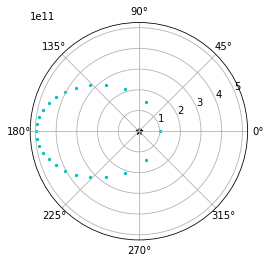

In [5]:
#Plotting in polar coords
ax=plt.subplot(111, polar=True)
ax.scatter(0,0, color='k', marker='*', s=50)
for i, t in enumerate(times):
    ax.scatter(true_anomalies[i], rs[i], color='c', s=5)
plt.show()

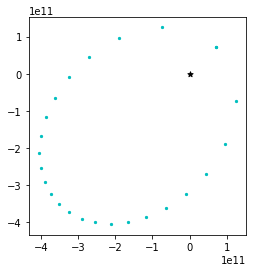

In [6]:
#Plotting in cartesian coords, checking that adding inside trig functions will rotate orbit
f,ax=plt.subplots(1,1)
ax.set_aspect('equal')
ax.scatter(0,0, marker='*', color='k', s=30)
arg=(np.pi/4.)*u.rad
for i, t in enumerate(times):
    ax.scatter(rs[i]*np.cos(true_anomalies[i]+arg), rs[i]*np.sin(true_anomalies[i]+arg), color='c', s=5)
plt.show()

In [7]:
t_yrs=[t.to('year') for t in times]

In [8]:
def mas_unc_to_m_unc(dist, mas_unc):
    ''' Converts mas uncertainties to meters at the plane of the system.'''
    radians_unc=mas_unc.to('rad')
    m_unc=np.tan(radians_unc)*dist
    return m_unc.to('m')

#Paper I'm imitating (Wang et al. 2016: 1607.05272) has ~1mas uncertainties on position, ~.2degree uncertainties on position angle
#I use larger uncertainties, will make an argument of a future function
sigma_true_anomaly=(1*u.deg).to('rad')
sigma_r=mas_unc_to_m_unc(distance_to_star, 10*u.mas) 


sigma_mass=.05*mstar
sigma_dist=.01*distance_to_star

# Add gaussian noise to the data

In [9]:
noisy_rs=rs+sigma_r*np.random.normal(loc=0, size=len(rs))
noisy_true_anomalies=true_anomalies+sigma_true_anomaly*np.random.normal(loc=0, size=len(true_anomalies))
noisy_mass=mstar+sigma_mass*np.random.normal(loc=0, size=1)
noisy_distance=distance_to_star+sigma_dist*np.random.normal(loc=0, size=1)

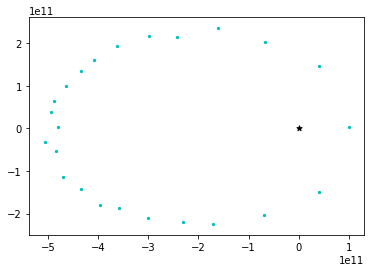

In [10]:
#Cartesian plot of data with gaussian noise
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[:-1]):
    ax.scatter(noisy_rs[i]*np.cos(noisy_true_anomalies[i]), noisy_rs[i]*np.sin(noisy_true_anomalies[i]), color='c', s=5)
plt.show()

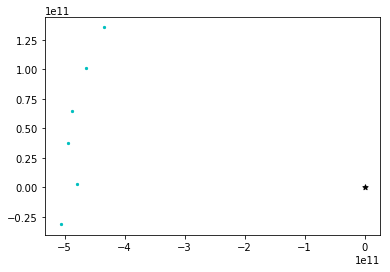

In [11]:
data=[noisy_true_anomalies[8:14], noisy_rs[8:14]]
info=[times[8:14], sigma_true_anomaly, sigma_r]
#Cartesian plot of noisy data the mcmc will run on
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[8:14]):
    ax.scatter(data[1][i]*np.cos(data[0][i]), data[1][i]*np.sin(data[0][i]), color='c', s=5)
plt.show()

In [12]:
def lnlike(pars, data, info):
    mpm, e, a, time_periastron, arg_periastron = pars #Unpack parameters
    mpm=mpm*u.kg #Total mass
    a=a*u.m #Semimajor axis
    T=np.sqrt(4.*np.pi**2.*a**3./(cons.G*mpm)) #Period
    times, sigma_theta, sigma_r = info #Unpacking info (time values, uncertainties)
    thetas, rs=data #Unpacking data
    mean_anomalies=(2.*np.pi)*(times-time_periastron*T)/T #Calculating mean anomalies
    chis=np.zeros(len(times)*2) #For each time, two distances to calculate
    for i in range(len(times)):
        k=0.85
        mean_anomaly=mean_anomalies[i]
        eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e
        eccentric_anomaly_i=eccentric_anomaly_0
        for j in range(10):
            fppp=e*np.cos(eccentric_anomaly_i*u.rad)
            fpp=e*np.sin(eccentric_anomaly_i*u.rad)
            fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
            f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
            d1=-f/fp
            d2=-f/(fp+.5*d1*fpp)
            d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
            eccentric_anomaly_next=eccentric_anomaly_i+d3
            eccentric_anomaly_i=eccentric_anomaly_next
        cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
        true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
        true_r=a*(1.-e**2.)/(1.+e*np.cos(true_anomaly+arg_periastron*u.rad))
        chis[2*i]=(thetas[i]-true_anomaly)/sigma_theta
        chis[2*i+1]=(rs[i]-true_r)/sigma_r
    chis=np.array(chis)
    return -0.5*(np.sum(chis*chis))

# generate first guess

In [55]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
#op.minimize(function, [first guess], args=(data, info))
result = op.minimize(nll, [(noisy_mass+mplanet).value, e, a.value, 0, 0], (data, info))
minv = result["x"]
minv[0]=minv[0][0]


In [56]:
minv=np.array(minv, dtype=float)
minv

array([  2.15154608e+30,   6.60000000e-01,   2.99195741e+11,
         0.00000000e+00,   0.00000000e+00])

In [57]:
lnlike(minv, data, info)

-64028.566307256726

In [58]:
#Flat priors in each parameter, inspired by those used for Beta Pic b in (Wang et al. 2016: 1607.05272)
def lnprior(pars):
    mpm, e, a, time_periastron, arg_periastron = pars
    if (1*cons.M_sun.value < mpm < 6*cons.M_sun.value) and (0.0001 < e < 0.99) and (1*cons.au.value < a < 20*cons.au.value) and (-1 < time_periastron < 1) and (-2*np.pi < arg_periastron < 2*np.pi):
        return 0.0
    return -np.inf

In [59]:
def lnprob(pars, data, info):
    lp = lnprior(pars)
    if ~(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(pars, data, info)

In [94]:
ndim, nwalkers = 5, 100
pos = [minv + 1e-2*np.array([5.*cons.M_sun.value, 1., 19.*cons.au.value, 2., 4.*np.pi])*np.random.randn(ndim) for i in range(nwalkers)]

In [101]:
1e-2*np.array([5.*cons.M_sun.value, 1., 19.*cons.au.value, 2., 4.*np.pi])*np.random.randn(ndim)

array([ -4.66849698e+28,  -1.83993996e-02,   2.02974015e+10,
         1.18964867e-02,   3.29550818e-02])

In [95]:
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=lnprob, args=(data, info))

In [96]:
np.isinf(lnprior(minv+[0, 0, 0, 0, 3*np.pi]))

True

In [97]:
sampler.run_mcmc(pos0=pos, N=50)

/Code/Anaconda/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Code/Anaconda/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  2.04998564e+30,   6.98159372e-01,   4.31292646e+11,
           8.30139056e-02,  -1.38775015e-01],
        [  2.16839967e+30,   6.62256061e-01,   2.98453589e+11,
           4.03355903e-02,   6.84295110e-02],
        [  2.20099563e+30,   7.31270520e-01,   2.88563792e+11,
           5.80730411e-02,   4.64807075e-02],
        [  2.07039904e+30,   6.15965342e-01,   3.95682297e+11,
           1.09796109e-01,   1.18593282e-01],
        [  2.08500268e+30,   6.60641749e-01,   3.04919020e+11,
          -4.48823044e-04,  -4.75967209e-02],
        [  2.05951691e+30,   6.89828374e-01,   2.93193675e+11,
           2.71310929e-02,   2.78331817e-02],
        [  2.11522449e+30,   6.70703527e-01,   2.98094414e+11,
           2.57486808e-02,   1.52255820e-02],
        [  2.03807322e+30,   6.73183642e-01,   4.79070614e+11,
           7.57953210e-02,   6.99814675e-02],
        [  2.13571312e+30,   6.59122894e-01,   3.06823180e+11,
          -5.79432982e-04,  -4.17291059e-02],
        [  2.024383

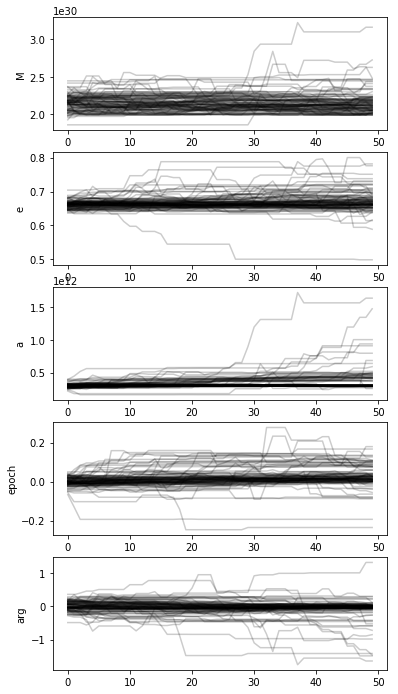

In [98]:
f, axs=plt.subplots(5,1, figsize=(6,12))
for i, ax in enumerate(f.axes):
    for j in range(sampler.chain.shape[0]):
        ax.plot(sampler.chain[j,:,i], color='k', alpha=0.2)
        ax.set_ylabel(['M', 'e', 'a', 'epoch', 'arg'][i])
plt.show()

In [99]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

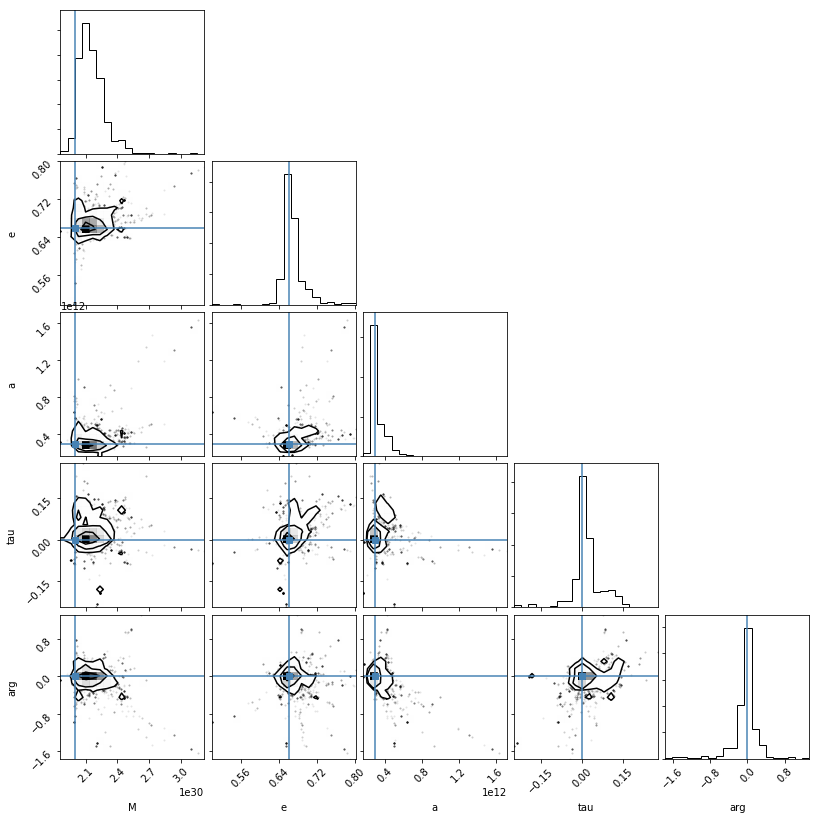

In [104]:
fig = corner.corner(samples[:,:], labels=["M", "e", "a", "tau", "arg"], truths=[(mstar+mplanet).value, e, a.value, 0, 0])
plt.show(fig)

In [93]:
for i in range(5):
    print(samples[:,i].min(), samples[:,i].max())

2.13097137179e+30 2.20653013167e+30
0.634135471267 0.686939842755
285858782240.0 299990686569.0
-0.00909528612726 0.0202331491295
-0.202471121221 0.262665025491


for standard ensemble sampler, use many walkers, few steps
for metropolis hastings, use few walkers, many many steps

use covariance matrix from optimization to initialize walkers